In [12]:
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [13]:
bbh_text = np.genfromtxt("/home/daniel/data/imrphenom-test/bbh_mass1_only_hp.txt", delimiter=" ")

In [14]:
bbh = data.Data(bbh_text[:,:2], bbh_text[:,2],              
                    target_names = ["Times", "Mass Ratio"],
                    label_names = ["hp strain"],
                    test_size = 0
                    )

In [15]:
from heron import regression
from heron import kernels

In [33]:
gp = regression.Regressor(bbh, kernel=kernels.SquaredExponential(ndim=2),yerror = 1e-3)

In [34]:
from scipy.optimize import minimize

In [35]:

from scipy.optimize import minimize
def nll(p):
    #p[0] = (1/np.std(gp.training_y))**2
    gp.set_hyperparameters(p)
    ll = gp.loglikelihood()
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_hyperparameters(p)
    return -gp.grad_loglikelihood()

In [38]:
set(bbh_text[:,1])

{5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5}

In [41]:
x0 = [(1/np.std(gp.training_y))**2, 50, 10]
res = minimize(nll, x0, method='BFGS', jac=grad_nll ,options={'disp': True})
gp.kernel.hyper

         Current function value: -1141.360387
         Iterations: 2
         Function evaluations: 84
         Gradient evaluations: 72


[32.51253820550837, [array([ 40.87557737,  -2.97740949])]]

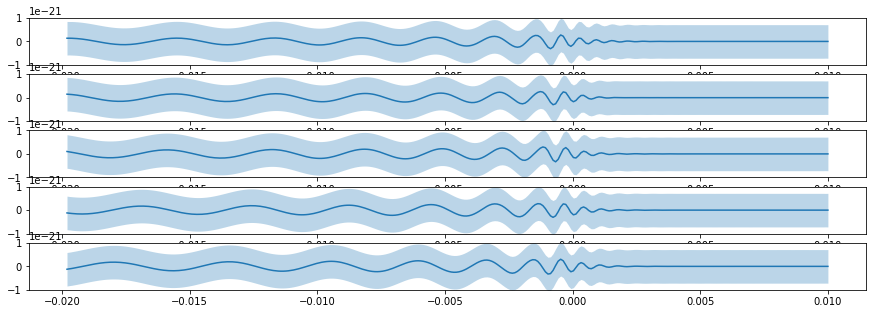

In [39]:
f, ax = plt.subplots(5,1, sharey=True, figsize=(15,5))
test_point = 0
for i in range(5):

    new_point = np.atleast_2d(bbh.targets[1+150*i])
    new_point = np.tile(new_point, (300,1))
    #new_point[:,1] = 0.2*i+0.2
    new_point[:,0] = np.linspace(0,1,300)
    ax[i].set_ylim([-1e-21, 1e-21])
    pred = gp.prediction(new_point)
    x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,0]
    ax[i].plot(x, pred[0])
    #plt.xlim([0,gp.training_object.targets_scale[1][i]])
    #ax[i].set_xlabel(gp.training_object.target_names[i])
    #plt.xlabel(r"Superplasticiser [kg / m$^3$]")
    #ax.set_ylabel("Compressive Strength [MPa]")
    err = np.diag(pred[1])
    err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
    err *= 1.96
    #ax[i].plot(concrete_txt[(i*150):(i+1)*150,0], concrete_txt[(i*150):(i+1)*150,2])
    ax[i].fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
    #ax[i].plot(gp.training_object.denormalise(bbh.targets[test_point], gp.training_object.targets_scale)[i], 
    #        gp.training_object.denormalise(bbh.test_labels, gp.training_object.labels_scale)[test_point], '.')
    #plt.savefig('superplasticiser.png', dpi=300)

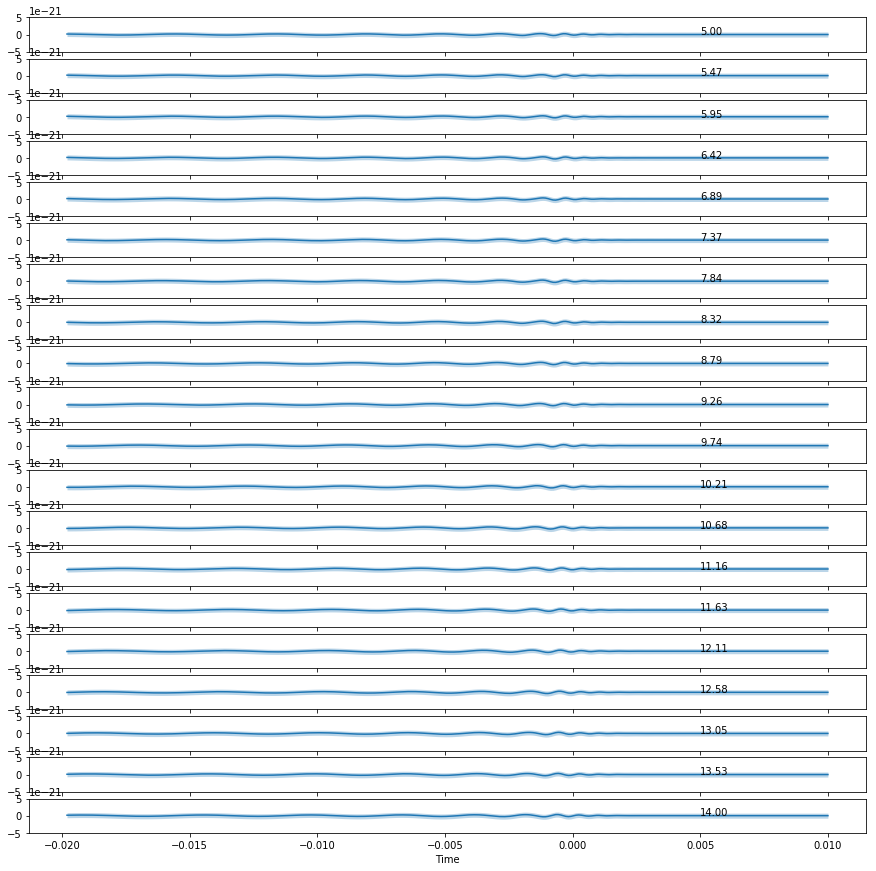

In [12]:
mass = (np.linspace(5,14, 20) - 5)/10
f, ax = plt.subplots(len(mass),1, sharey=True, figsize=(15,15))
test_point = 0

for i in range(len(mass)):
    new_point = np.atleast_2d(bbh.targets[test_point])
    new_point = np.tile(new_point, (300,1))
    new_point[:,1] = mass[i]
    new_point[:,0] = np.linspace(0,1,300)
    pred = gp.prediction(new_point)
    x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,0]
    ax[i].plot(x, pred[0])
    ax[i].set_ylim([-5e-21, 5e-21])
    err = np.diag(pred[1])
    err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
    err *= 1.96
    ax[i].fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
    ax[i].set_xlabel("Time")
    ax[i].text(0.005,0,"{:.2f}".format((mass[i]*10)+5))

In [14]:
mass

array([ 0.66443081,  2.22222222])

In [95]:
(0.15 * bbh.targets_scale[1]) + bbh.targets_scale[0]

array([-0.01533015,  6.35      ])

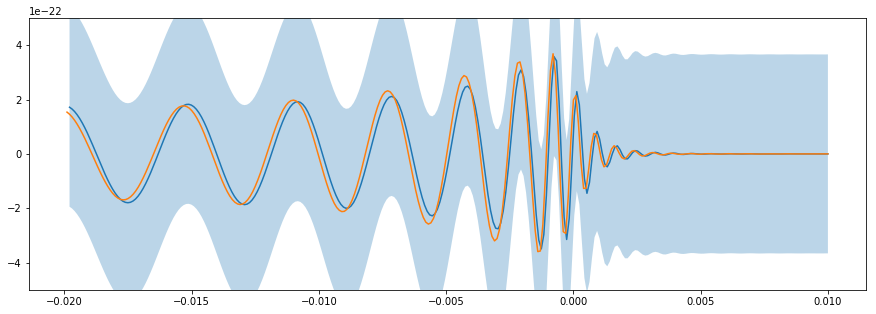

In [32]:
test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_7d85.txt')
f, ax = plt.subplots(1,1, sharey=True, figsize=(15,5))

#mass = [0,0.15]
mass = [0, 7.85]
mass = (mass - bbh.targets_scale[0]) / bbh.targets_scale[1]
new_point = np.atleast_2d(bbh.targets[test_point])
new_point = np.tile(new_point, (300,1))
new_point[:,1] = mass[1]#-0.001 #(mass - bbh.targets_scale[0])/bbh.targets_scale[1]#(7.5-5)/10.
new_point[:,0] = np.linspace(0.,1,300)
pred = gp.prediction(new_point)
x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,0]
ax.plot(x, pred[0])
ax.set_ylim([-.5e-21, .5e-21])
#plt.xlim([0,gp.training_object.targets_scale[1][i]])
#ax[i].set_xlabel(gp.training_object.target_names[i])
#plt.xlabel(r"Superplasticiser [kg / m$^3$]")
#ax.set_ylabel("Compressive Strength [MPa]")
err = np.diag(pred[1])
err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
#err *= 1.96
#ax[i].plot(concrete_txt[(i*150):(i+1)*150,0], concrete_txt[(i*150):(i+1)*150,2])
ax.fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
ax.plot(test.T[0], test.T[2])

In [31]:
mass

array([ 0.66443101,  0.63333333])

In [20]:
set(bbh_text[:,1])

{5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0}

In [31]:
test.T[0][1] - test.T[0][0]

9.9999999999999395e-05

In [64]:
concrete_txt

array([[ -1.98000630e-02,   1.09370083e+31,   1.48589303e-22],
       [ -1.96000630e-02,   1.09370083e+31,   1.32339556e-22],
       [ -1.94000620e-02,   1.09370083e+31,   1.06136828e-22],
       ..., 
       [  9.59997500e-03,   1.54112389e+31,  -1.33369821e-25],
       [  9.79997600e-03,   1.54112389e+31,   2.12725659e-26],
       [  9.99997600e-03,   1.54112389e+31,   1.05846855e-26]])

In [120]:
mass = [0, 2.0879743027095344e+31]
(mass - bbh.targets_scale[0]) / bbh.targets_scale[1]

array([ 0.66443606,  0.61111111])

In [100]:
bbh.denormalise(0.835, bbh.targets_scale[1]) / mass

1.0019999999999998

In [79]:
bbh.targets_scale#[0]

(array([ -1.98004570e-02,   9.94273477e+30]),
 array([  2.98003950e-02,   1.78969226e+31]))

In [75]:
bbh.targets

array([[  1.01676505e-05,   0.00000000e+00],
       [  6.72152164e-03,   0.00000000e+00],
       [  1.34328421e-02,   0.00000000e+00],
       ..., 
       [  9.86571218e-01,   1.00000000e+00],
       [  9.93282606e-01,   1.00000000e+00],
       [  9.99993960e-01,   1.00000000e+00]])

In [316]:
#ll = []
ll = np.zeros((10,10))
x = np.linspace(0.3,0.9, 10)
y = np.linspace(0,100, 10)
for i,a in enumerate(x):
    for j,b in enumerate(y):
        x0 = [a,b, 4]
        gp.set_hyperparameters(x0)
        ll[i,j] = gp.loglikelihood()

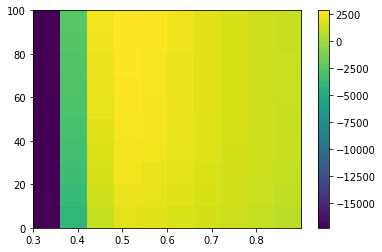

In [317]:
plt.imshow(ll, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.colorbar()

In [318]:
np.argmax(ll)

93

In [231]:
ll = []
x = np.linspace(0.78,0.8, 100)
for i in x:
    x0 = [i, 168, 4]
    gp.set_hyperparameters(x0)
    ll.append(gp.loglikelihood())

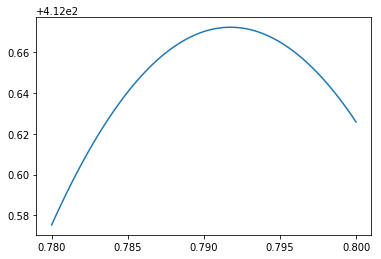

In [233]:
plt.plot(x,ll)

In [241]:
ll = []
x = np.linspace(31,33, 50)
for i in x:
    x0 = [0.7917, i, 4]
    gp.set_hyperparameters(x0)
    ll.append(gp.loglikelihood())

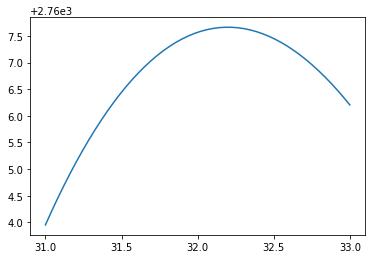

In [242]:
plt.plot(x,ll)

In [243]:
x[np.argmax(ll)]

32.183673469387756

In [254]:
ll = []
x = np.linspace(6,6.2, 50)
for i in x:
    x0 = [0.7917, 32.18, i]
    gp.set_hyperparameters(x0)
    ll.append(gp.loglikelihood())

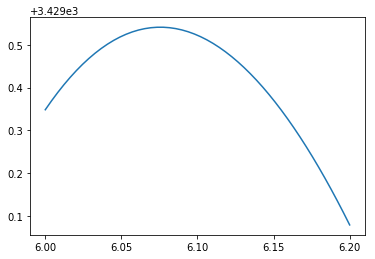

In [255]:
plt.plot(x,ll)

In [256]:
x[np.argmax(ll)]

6.0775510204081638

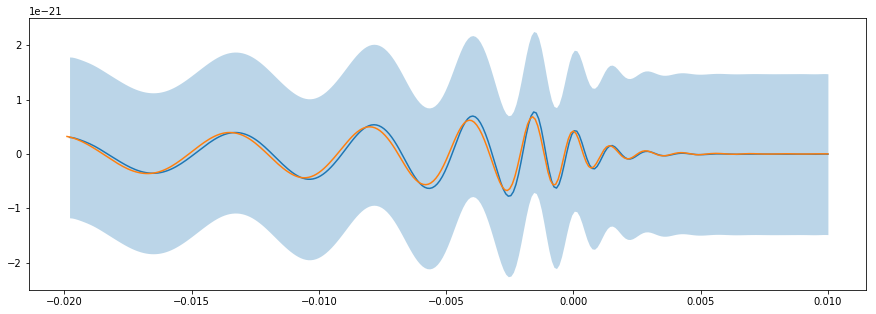

In [268]:

test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_45.txt')
f, ax = plt.subplots(1,1, sharey=True, figsize=(15,5))

mass = [0, 2.0879743027095344e+31]
mass = (mass - bbh.targets_scale[0]) / bbh.targets_scale[1]#+0.5
#mass = [0,0.1]
#x0 = [59.28, 82.9, 2.2]
x0 = [0.7917, 32.18, 6.07755]
#x0 = [0.029974254529549851,  101.2117402 ,    0.84988828]
gp.set_hyperparameters(x0)
new_point = np.atleast_2d(bbh.targets[test_point])
new_point = np.tile(new_point, (300,1))
new_point[:,1] = mass[1] #(mass - bbh.targets_scale[0])/bbh.targets_scale[1]#(7.5-5)/10.
new_point[:,0] = np.linspace(0,1,300)
pred = gp.prediction(new_point)
x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,0]
ax.plot(x, pred[0])
ax.set_ylim([-2.5e-21, 2.5e-21])
#plt.xlim([0,gp.training_object.targets_scale[1][i]])
#ax[i].set_xlabel(gp.training_object.target_names[i])
#plt.xlabel(r"Superplasticiser [kg / m$^3$]")
#ax.set_ylabel("Compressive Strength [MPa]")
err = np.diag(pred[1])
err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
err *= 1.96
#ax[i].plot(concrete_txt[(i*150):(i+1)*150,0], concrete_txt[(i*150):(i+1)*150,2])
ax.fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
ax.plot(test.T[0], test.T[2])

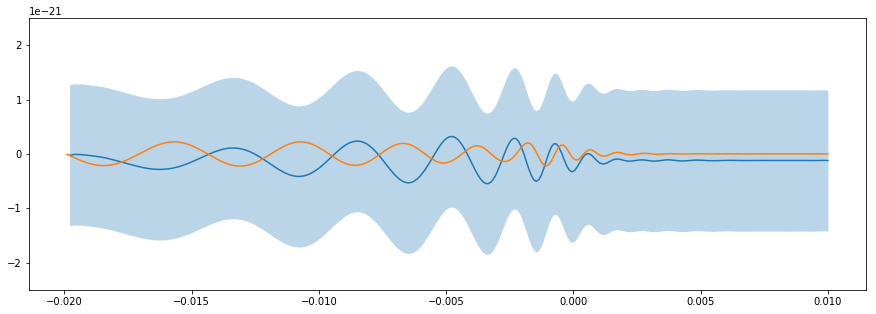

In [258]:
test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_75.txt')
f, ax = plt.subplots(1,1, sharey=True, figsize=(15,5))

mass = [0,8.948461297326577e+30]
mass = (mass - bbh.targets_scale[0]) / bbh.targets_scale[1]#+0.5
#mass = [0,0.1]
x0 = [0.7917, 32.18, 6.07755]
#x0 = [0.029974254529549851,  101.2117402 ,    0.84988828]
gp.set_hyperparameters(x0)
new_point = np.atleast_2d(bbh.targets[test_point])
new_point = np.tile(new_point, (300,1))
new_point[:,1] = mass[1] #(mass - bbh.targets_scale[0])/bbh.targets_scale[1]#(7.5-5)/10.
new_point[:,0] = np.linspace(0,1,300)
pred = gp.prediction(new_point)
x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,0]
ax.plot(x, pred[0])
ax.set_ylim([-2.5e-21, 2.5e-21])
#plt.xlim([0,gp.training_object.targets_scale[1][i]])
#ax[i].set_xlabel(gp.training_object.target_names[i])
#plt.xlabel(r"Superplasticiser [kg / m$^3$]")
#ax.set_ylabel("Compressive Strength [MPa]")
err = np.diag(pred[1])
err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
err *= 1.96
#ax[i].plot(concrete_txt[(i*150):(i+1)*150,0], concrete_txt[(i*150):(i+1)*150,2])
ax.fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
ax.plot(test.T[0], test.T[2])

In [260]:
import emcee

def nll(p):
    #p[0] = (1/np.std(gp.training_y))**2
    gp.set_hyperparameters(p)
    ll = gp.loglikelihood()
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    p[0] = 1
    gp.set_hyperparameters(p)
    return -gp.grad_loglikelihood()

ndim, nwalkers = 3, 100
#ivar = 1. / np.random.rand(ndim)
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, nll, args=[])
sampler.run_mcmc(p0, 1000)

emcee: Exception while calling your likelihood function:
  params: [  2.59614750e-04  -2.23710414e+07  -1.66222958e+07]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-260-1e7a25286355>", line 5, in nll
    gp.set_hyperparameters(p)
  File "build/bdist.linux-x86_64/egg/heron/regression.py", line 84, in set_hyperparameters
    return self.loglikelihood()
  File "build/bdist.linux-x86_64/egg/heron/regression.py", line 134, in loglikelihood
    LD = np.linalg.slogdet(self.K_matrix())
  File "/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/numpy-1.11.1-py2.7-linux-x86_64.egg/numpy/linalg/linalg.py", line 1712, in slogdet
    sign, logdet = _umath_linalg.slogdet(a, signature=signature)
KeyboardInterrupt


KeyboardInterrupt: 

In [264]:
import corner

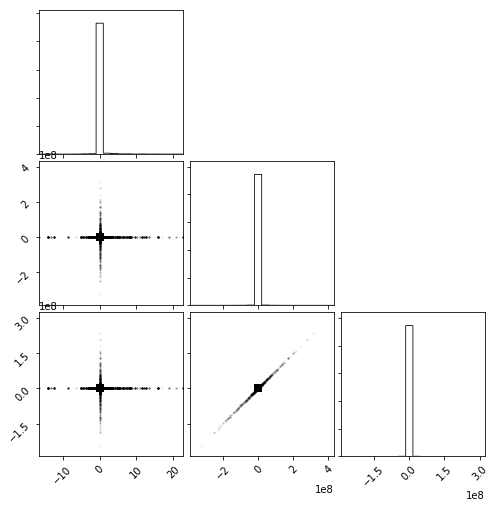

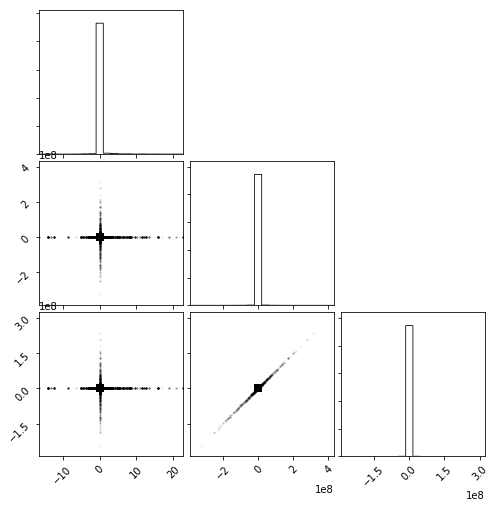

In [267]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
corner.corner(samples)

In [45]:
def slicer(vector, ax = None):
    return vector[ax]

In [47]:
a = np.ones((3,3))

In [56]:
bbh.targets[1,:]

array([ 0.00671323,  0.        ])

In [52]:
slice(1,2)

slice(1, 2, None)